In [63]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from tabulate import tabulate

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge

from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

# Varios
# ==============================================================================
import multiprocessing
import random
from itertools import product
from fitter import Fitter, get_common_distributions
# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

#### Traemos el archivo csv con el que vamos a trabajar y lo connvertimos a DataFrame

In [18]:
#Pasamos el archivo csv  a DataFrame 
datos = pd.read_csv('SaratogaHouses.csv')

#imprimimos los primeros 5  renglones con sus valores del DataFrame
print(display(datos.head()))

,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms,heating,fuel,sewer,waterfront,newConstruction,centralAir
0,132500,0.09,42,50000,906,35,2,1,1.0,5,electric,electric,septic,No,No,No
1,181115,0.92,0,22300,1953,51,3,0,2.5,6,hot water/steam,gas,septic,No,No,No
2,109000,0.19,133,7300,1944,51,4,1,1.0,8,hot water/steam,gas,public/commercial,No,No,No
3,155000,0.41,13,18700,1944,51,3,1,1.5,5,hot air,gas,septic,No,No,No
4,86060,0.11,0,15000,840,51,2,0,1.0,3,hot air,gas,public/commercial,No,Yes,Yes


None


In [22]:
# Se renombran las columnas para que sean entendibles 
datos.columns = ["precio", "metros_totales", "antiguedad", "precio_terreno",
                 "metros_habitables", "universitarios", "dormitorios", 
                 "chimenea", "banyos", "habitaciones", "calefaccion",
                 "consumo_calefacion", "desague", "vistas_lago",
                 "nueva_construccion", "aire_acondicionado"]
print(display(datos.head()))

,precio,metros_totales,antiguedad,precio_terreno,metros_habitables,universitarios,dormitorios,chimenea,banyos,habitaciones,calefaccion,consumo_calefacion,desague,vistas_lago,nueva_construccion,aire_acondicionado
0,132500,0.09,42,50000,906,35,2,1,1.0,5,electric,electric,septic,No,No,No
1,181115,0.92,0,22300,1953,51,3,0,2.5,6,hot water/steam,gas,septic,No,No,No
2,109000,0.19,133,7300,1944,51,4,1,1.0,8,hot water/steam,gas,public/commercial,No,No,No
3,155000,0.41,13,18700,1944,51,3,1,1.5,5,hot air,gas,septic,No,No,No
4,86060,0.11,0,15000,840,51,2,0,1.0,3,hot air,gas,public/commercial,No,Yes,Yes


None


In [64]:
#Dimension del dataset
print(datos.shape)

(1728, 16)


### Variable respuesta
- Cuando se crea un modelo, es muy importante estudiar la distribución de la variable respuesta, ya que, a fin de cuentas, es lo que interesa predecir. La variable precio tiene una distribución asimétrica con una cola positiva debido a que, unas pocas viviendas, tienen un precio muy superior a la media. Este tipo de distribución suele visualizarse mejor tras aplicar el logarítmica o la raíz cuadrada.

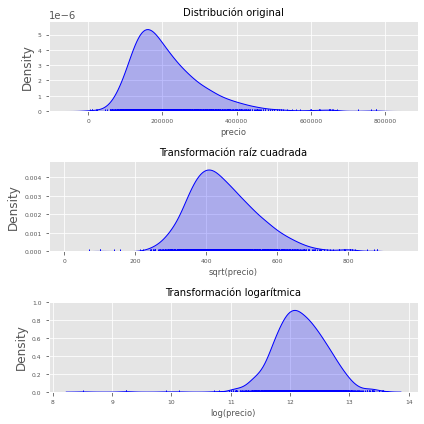

In [65]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 6))
sns.distplot(
    datos.precio,
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[0]
)
axes[0].set_title("Distribución original", fontsize = 'medium')
axes[0].set_xlabel('precio', fontsize='small') 
axes[0].tick_params(labelsize = 6)

sns.distplot(
    np.sqrt(datos.precio),
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[1]
)
axes[1].set_title("Transformación raíz cuadrada", fontsize = 'medium')
axes[1].set_xlabel('sqrt(precio)', fontsize='small') 
axes[1].tick_params(labelsize = 6)

sns.distplot(
    np.log(datos.precio),
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[2]
)
axes[2].set_title("Transformación logarítmica", fontsize = 'medium')
axes[2].set_xlabel('log(precio)', fontsize='small') 
axes[2].tick_params(labelsize = 6)

fig.tight_layout()

<b> División train y test </b>


- Evaluar la capacidad predictiva de un modelo consiste en comprobar cómo de próximas son sus predicciones a los verdaderos valores de la variable respuesta. Para poder cuantificarlo de forma correcta, se necesita disponer de un conjunto de observaciones, de las que se conozca la variable respuesta, pero que el modelo no haya "visto", es decir, que no hayan participado en su ajuste. Con esta finalidad, se dividen los datos disponibles en un conjunto de entrenamiento y un conjunto de test. 
- El tamaño adecuado de las particiones depende en gran medida de la cantidad de datos disponibles y la seguridad que se necesite en la estimación del error, 80%-20% suele dar buenos resultados. El reparto debe hacerse de forma aleatoria o aleatoria-estratificada.

In [30]:
# Reparto de datos en train y test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop('precio', axis = 'columns'),
                                        datos['precio'],
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

- Es importante verificar que la distribución de la variable respuesta es similar en el conjunto de entrenamiento y en el de test. Para asegurar que esto se cumple, la función <b> <span style="color:orange">train_test_split()</span></b> de <b> <span style="color:orange">Sciket-learn</span></b>  permite , en problemas de clasificación, identificar con el argumento <b> <span style="color:orange">Stratifay</span></b> la variable en base a la cual hacer el reparto.

- Este tipo de reparto estratificado asegura que el conjunto de entrenamiento y el de test sean similares en cuanto a la variable respuesta, sin embargo, no garantiza que ocurra lo mismo con los predictores. Por ejemplo, en un set de datos con 100 observaciones, un predictor binario que tenga 90 observaciones de un grupo y solo 10 de otro, tiene un alto riesgo de que, en alguna de las particiones, el grupo minoritario no tenga representantes. Si esto ocurre en el conjunto de entrenamiento, algunos algoritmos darán error al aplicarlos al conjunto de test, ya que no entenderán el valor que se les está pasando. Este problema puede evitarse eliminando variables con varianza próxima a cero (ver más adelante).

In [34]:

print("Partición de entrenamento")
print("-----------------------")
print(y_train.describe())

Partición de entrenamento
-----------------------
count      1382.000000
mean     211436.516643
std       96846.639129
min       10300.000000
25%      145625.000000
50%      190000.000000
75%      255000.000000
max      775000.000000
Name: precio, dtype: float64


In [36]:
print("Partición de test")
print("-----------------------")
print(y_test.describe())

Partición de test
-----------------------
count       346.000000
mean     214084.395954
std      104689.155889
min        5000.000000
25%      139000.000000
50%      180750.000000
75%      271750.000000
max      670000.000000
Name: precio, dtype: float64


#### <b>Preprocesado </b>


- El preprocesado engloba todas aquellas transformaciones realizadas sobre los datos con el objetivo que puedan ser interpretados por el algoritmo de machine learning lo más eficientemente posible. Todo preprocesado de datos debe aprenderse con las observaciones de entrenamiento y luego aplicarse al conjunto de entrenamiento y al de test. Esto es muy importante para no violar la condición de que ninguna información procedente de las observaciones de test participe o influya en el ajuste del modelo. Este principio debe aplicarse también si se emplea validación cruzada (ver más adelante). En tal caso, el preprocesado debe realizarse dentro de cada iteración de validación, para que las estimaciones que se hacen con cada partición de validación no contengan información del resto de particiones. Aunque no es posible crear un único listado, a continuación se resumen algunos de los pasos de preprocesado que más se suelen necesitar.

#### <b>Imputación de valores ausentes </b>


- La gran mayoría de algoritmos no aceptan observaciones incompletas, por lo que, cuando el set de datos contiene valores ausentes, se puede:

- Eliminar aquellas observaciones que estén incompletas.

- Eliminar aquellas variables que contengan valores ausentes.

- Tratar de estimar los valores ausentes empleando el resto de información disponible (imputación).

- Las primeras dos opciones, aunque sencillas, suponen perder información. La eliminación de observaciones solo puede aplicarse cuando se dispone de muchas y el porcentaje de registros incompletos es muy bajo. En el caso de eliminar variables, el impacto dependerá de cuánta información aporten dichas variables al modelo. Cuando se emplea la imputación, es muy importante tener en cuenta el riesgo que se corre al introducir valores en predictores que tengan mucha influencia en el modelo. Supóngase un estudio médico en el que, cuando uno de los predictores es positivo, el modelo predice casi siempre que el paciente está sano. Para un paciente cuyo valor de este predictor se desconoce, el riesgo de que la imputación sea errónea es muy alto, por lo que es preferible obtener una predicción basada únicamente en la información disponible. Esta es otra muestra de la importancia que tiene que el analista conozca el problema al que se enfrenta y pueda así tomar la mejor decisión.

<b> <span style="color:orange">El modulo sklearn.impute</span></b> incorpora varios métodos de imputación distintos:

- SimpleImputer: permite imputaciones empleando un valor constante o un estadístico (media, mediana, valor más frecuente) de la misma columna en la que se encuentra el valor ausente.

- IterativeImputer: permite imputar el valor de una columna teniendo en cuenta el resto de columnas. En concreto, se trata de un proceso iterativo en el que, en cada iteración, una de las variables se emplea como variable respuesta y el resto como predictores. Una vez obtenido el modelo, se emplea para predecir las posiciones vacías de esa variable. Este proceso se lleva a cabo con cada variable y se repite el ciclo max_iter veces para ganar estabilidad. La implementación de sklearn.impute.IterativeImputer permite que se emplee casi cualquiera de sus algoritmos para crear los modelos de imputación (KNN, RandomForest, GradientBoosting...).

- KNNImputer: es un caso concreto de IterativeImputer en el que se emplea k-Nearest Neighbors como algoritmo de imputación.

- A pesar de ser un método muy utilizado, imputar utilizando KNN presenta dos problemas: su coste computacional elevado hace que solo sea aplicable en conjuntos de datos de tamaño pequeño o moderado. Si hay variables categóricas, debido a la dificultad de medir "distancias" en este contexto, puede dar lugar a resultados poco realistas. Por estas dos razones, es más recomendable utilizar un modelo tipo Random Forest IterativeImputer(predictor = RandomForestRegressor()).

- Con el argumento add_indicator=True se crea automáticamente una nueva columna en la que se indica con el valor 1 qué valores han sido imputados. Esto puede ser útil tanto para identificar las observaciones en las que se ha realizado alguna imputación como para utilizarla como un predictor más en el modelo.

#### <b>Exclusión de variables con varianza próxima a cero</b>


- No se deben incluir en el modelo predictores que contengan un único valor (cero-varianza) ya que no aportan información. Tampoco es conveniente incluir predictores que tengan una varianza próxima a cero, es decir, predictores que toman solo unos pocos valores, de los cuales, algunos aparecen con muy poca frecuencia. El problema con estos últimos es que pueden convertirse en predictores con varianza cero cuando se dividen las observaciones por validación cruzada o bootstrap.

- La clase <b>VarianceThreshold </b> del módulo <b> sklearn.feature_selection </b> identifica y excluye todos aquellos predictores cuya varianza no supera un determinado threshold. En el caso de variables cualitativas, cabe recordar que scikitlearn requiere que se binaricen (one hot encoding o dummy) para poder entrenar los modelos. Una variable booleana sigue una distribución de Bernoulli, por lo que su varianza puede ser calculada como:
 <b> <span style="color:red">  $  Var[X]=p(1−p) $   </span></b>
 
- Si bien la eliminación de predictores no informativos podría considerarse un paso propio del proceso de selección de predictores, dado que consiste en un filtrado por varianza, tiene que realizarse antes de estandarizar los datos, ya que después, todos los predictores tienen varianza 1.



#### Estandarización y escalado de variables numéricas


- Cuando los predictores son numéricos, la escala en la que se miden, así como la magnitud de su varianza pueden influir en gran medida en el modelo. Muchos algoritmos de machine learning (SVM, redes neuronales, lasso...) son sensibles a esto, de forma que, si no se igualan de alguna forma los predictores, aquellos que se midan en una escala mayor o que tengan más varianza dominarán el modelo aunque no sean los que más relación tienen con la variable respuesta. Existen principalmente 2 estrategias para evitarlo:

- Centrado: consiste en restarle a cada valor la media del predictor al que pertenece. Si los datos están almacenados en un dataframe, el centrado se consigue restándole a cada valor la media de la columna en la que se encuentra. Como resultado de esta transformación, todos los predictores pasan a tener una media de cero, es decir, los valores se centran en torno al origen. StandardScaler(with_std=False)

- Normalización (estandarización): consiste en transformar los datos de forma que todos los predictores estén aproximadamente en la misma escala. Hay dos formas de lograrlo:

- Normalización Z-score (StandardScaler): dividir cada predictor entre su desviación típica después de haber sido centrado, de esta forma, los datos pasan a tener una distribución normal.

 ## $   z= \frac{x−μ}{σ}$
 
- Estandarización max-min (MinMaxScaler): transformar los datos de forma que estén dentro del rango [0, 1].

## $ X_{norm}= \frac{X−X_{min}}{X_{max}−X_{min} }$
 
- Nunca se deben estandarizar las variables después de ser binarizadas (ver a continuación).

#### Binarización de las variables cualitativas


- La binarización (one-hot-encoding) consiste en crear nuevas variables dummy con cada uno de los niveles de las variables cualitativas. Por ejemplo, una variable llamada color que contenga los niveles rojo, verde y azul, se convertirá en tres nuevas variables (color_rojo, color_verde, color_azul), todas con el valor 0 excepto la que coincide con la observación, que toma el valor 1.

- Por defecto, la clase OneHotEncoder binariza todas las variables, por lo que hay que aplicarlo únicamente a las variables cualitativas (ver como hacerlo en el apartado ColumnTransformer). Con el argumento drop=‘first’ se elimina uno de los niveles para evitar redundancias. Volviendo al ejemplo anterior, no es necesario almacenar las tres variables, ya que, si color_rojo y color_verde toman el valor 0, la variable color_azul toma necesariamente el valor 1. Si color_rojo o color_verde toman el valor 1, entonces color_azul es necesariamente 0. Esto es importante en modelos que sufren problemas si los predictores están perfectamente correlacionados (modelos lineales sin regularización, redes neuronales...).

- En ciertos escenarios puede ocurrir que, en los datos de test, aparezca un nuevo nivel que no estaba en los datos de entrenamiento. Si no se conoce de antemano cuáles son todos los posibles niveles, se puede evitar errores en las predicciones indicando OneHotEncoder(handle_unknown='ignore').

- La forma de preprocesar los datos dentro del ecosistema scikit-learn es empleando los ColumnTransformer y pipeline. Además de las ya mencionadas, pueden encontrarse muchas más transformaciones de preprocesado en el módulo sklearn.preprocessing.

#### Pipeline y ColumnTransformer


- Las clases ColumnTransformer y make_column_transformer del módulo sklearn.compose permiten combinar múltiples transformaciones de preprocesado, especificando a qué columnas se aplica cada una. Como todo transformer, tiene un método de entrenamiento (fit) y otro de transformación (transform) . Esto permite que el aprendizaje de las transformaciones se haga únicamente con observaciones de entrenamiento, y se puedan aplicar después a cualquier conjunto de datos. La idea detrás de este módulo es la siguiente:

- Definir todas las transformaciones (escalado, selección, filtrado...) que se desea aplicar y a qué columnas ColumnTransformer(). La selección de columnas puede hacerse por: nombre. índice, máscara booleana, slice, patrón regex, por tipo de columna o con las funciones de selección make_column_selector.

- Aprender los parámetros necesarios para dichas transformaciones con las observaciones de entrenamiento .fit().

- Aplicar las transformaciones aprendidas a cualquier conjunto de datos .transform().

In [38]:
# Selección de las variables por típo
# ==============================================================================
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector

# Se estandarizan las columnas numéricas y se hace one-hot-encoding de las 
# columnas cualitativas. Para mantener las columnas a las que no se les aplica 
# ninguna transformación se tiene que indicar remainder='passthrough'.
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')

- Una vez que se ha definido el objeto ColumnTransformer, con el método fit() se aprenden las transformaciones con los datos de entrenamiento y se aplican a los dos conjuntos con transform().

In [40]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

- El resultado devuelto por ColumnTransformer es un numpy array, por lo que se pierden los nombres de las columnas. Suele ser interesante poder inspeccionar cómo queda el set de datos tras el preprocesado en formato dataframe. Por defecto, OneHotEncoder ordena las nuevas columnas de izquierda a derecha por orden alfabético.

In [43]:
# Convertir el output en dataframe y añadir el nombre de las columnas
# ==============================================================================
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])
datos_train_prep = preprocessor.transform(X_train)
datos_train_prep = pd.DataFrame(datos_train_prep, columns=labels)
datos_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1382 entries, 0 to 1381
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   metros_totales               1382 non-null   float64
 1   antiguedad                   1382 non-null   float64
 2   precio_terreno               1382 non-null   float64
 3   metros_habitables            1382 non-null   float64
 4   universitarios               1382 non-null   float64
 5   dormitorios                  1382 non-null   float64
 6   chimenea                     1382 non-null   float64
 7   banyos                       1382 non-null   float64
 8   habitaciones                 1382 non-null   float64
 9   calefaccion_electric         1382 non-null   float64
 10  calefaccion_hot air          1382 non-null   float64
 11  calefaccion_hot water/steam  1382 non-null   float64
 12  consumo_calefacion_electric  1382 non-null   float64
 13  consumo_calefacion

- ColumnTransformer aplica las operaciones de forma paralela, no de forma secuencial, esto significa que no permite aplicar más de una transformación a una misma columna. En el caso de que sea necesario hacerlo, hay que recurrir a los pipeline, que también agrupan operaciones pero las ejecutan de forma secuencial, de forma que la salida de una operación es la entrada de la siguiente. Si se quieren aplicar varias transformaciones de preprocesado sobre una misma columna, es necesario agruparlas primero en un pipeline

En el siguiente ejemplo se combinan las transormaciones:

- Columnas numéricas: se imputan los valores ausentes con la mediana y a continuación se estandarizan.

- Columnas categóricas (cualitativas): se imputan los valores ausentes con el valor más frecuente y a continuación se aplica one hot encoding.

In [45]:
# Selección de las variables por típo
# ==============================================================================
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector

numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[
                            ('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())
                        ]
                      )


# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[
                                ('imputer', SimpleImputer(strategy='most_frequent')),
                                ('onehot', OneHotEncoder(handle_unknown='ignore'))
                            ]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

In [47]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

In [49]:
# Convertir el output en dataframe y añadir el nombre de las columnas
# ==============================================================================

encoded_cat = preprocessor.named_transformers_['cat']['onehot']\
              .get_feature_names(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])
datos_train_prep = preprocessor.transform(X_train)
datos_train_prep = pd.DataFrame(datos_train_prep, columns=labels)
datos_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1382 entries, 0 to 1381
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   metros_totales               1382 non-null   float64
 1   antiguedad                   1382 non-null   float64
 2   precio_terreno               1382 non-null   float64
 3   metros_habitables            1382 non-null   float64
 4   universitarios               1382 non-null   float64
 5   dormitorios                  1382 non-null   float64
 6   chimenea                     1382 non-null   float64
 7   banyos                       1382 non-null   float64
 8   habitaciones                 1382 non-null   float64
 9   calefaccion_electric         1382 non-null   float64
 10  calefaccion_hot air          1382 non-null   float64
 11  calefaccion_hot water/steam  1382 non-null   float64
 12  consumo_calefacion_electric  1382 non-null   float64
 13  consumo_calefacion

In [51]:
from sklearn import set_config
set_config(display='diagram')

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['metros_totales', 'antiguedad',
                                  'precio_terreno', 'metros_habitables',
                                  'universitarios', 'dormitorios', 'chimenea',
                                  'banyos', 'habitaciones']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['calefaccion', 'consumo_calefacion',
                                  'desague', 'vistas_lago',
                                  'nueva_construccion',
                                  'aire_acondicionado'])])

In [53]:
set_config(display='text')

## Crear un modelo


- El siguiente paso tras definir los datos de entrenamiento, es seleccionar el algoritmo que se va a emplear. En scikit-learn, esto se hace mediante la creación de un objeto estimator. En concreto, este objeto almacena el nombre del algoritmo, sus parámetros e hiperparámetros y contiene los métodos fit(X, y) y predict(T) que le permiten aprender de los datos y predecir nuevas observaciones. El siguiente listado contiene todos los algoritmos implementados en scikit-learn.

## Entrenamiento

- Se ajusta un primer modelo de regresión lineal con regularización ridge para predecir el precio de la vivienda en función de todos los predictores disponibles. Todos los argumentos de sklearn.linear_model.Ridge se dejan por defecto.

- Es importante tener en cuenta que, cuando un modelo de regresión lineal incluye regularización en los coeficientes (ridge, lasso, elasticnet), deben estandarizarse los predictores. Para asegurar que el preprocesado se realiza únicamente con los datos de entrenamiento, se combinan las transformaciones y el entrenamiento en un mismo pipeline.